# HW: Apple 
### Predicción de Series Temporales
#### Carlos Sebastiani

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.ets import AutoETS
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.utils.plotting import plot_correlations
from sktime.transformations.series.difference import Differencer
from sktime.forecasting.arima import AutoARIMA


In [2]:
# Reading data
apple_df = pd.read_csv('../apple/aapl.csv',sep=';',decimal=',')
apple_df['fecha'] = pd.to_datetime(apple_df['fecha']) ## converting to data format
apple_df = apple_df.set_index('fecha') ##setting columns date as a index
apple_df.head()

,Trimeste,Ingresos
fecha,,
1989-12-29,Q1 1990,1493.4
1990-03-30,Q2 1990,1346.2
1990-06-29,Q3 1990,1364.8
1990-09-28,Q4 1990,1354.1
1990-12-28,Q1 1991,1675.5


In [259]:
apple_ts_fy=apple_df.resample('Q-OCT').last()
apple_ts_a_fy = apple_ts_fy.asfreq('Q-OCT').resample('A-OCT').sum() ## Calculamos los valores anuales
apple_ts_fy.head(n=10)


,Trimeste,Ingresos
fecha,,
1990-01-31,Q1 1990,1493.4
1990-04-30,Q2 1990,1346.2
1990-07-31,Q3 1990,1364.8
1990-10-31,Q4 1990,1354.1
1991-01-31,Q1 1991,1675.5
...,...,...
2020-07-31,Q3 2020,59685.0
2020-10-31,Q4 2020,64698.0
2021-01-31,Q1 2021,111439.0


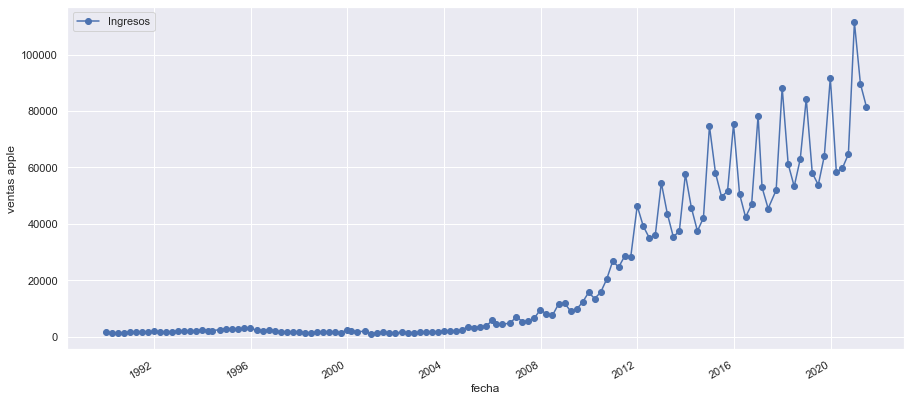

In [33]:
## Graficamos para observar como se comportan las ventas
sns.set(rc={'figure.figsize':(15, 7)})
ax = apple_df.plot(marker='o', linestyle='-')
ax.set_ylabel('ventas apple');

## Analizamos al estacionariedad



In [34]:
## Creamos formulas para revisar si la media y la varianza son estacionarias
def split_and_summarize(dataframe,column,size,fn):
    ranges = []
    values =[]
    for i in range(0,len(dataframe),size):
        ranges.append(dataframe[i:i+size])
    for i in ranges:
        values.append(fn(i[column]))
    return(values)

##Utilizamos la formula para obtener los valores de la media y la varianza
        
means = split_and_summarize(apple_df,'Ingresos',4,np.mean)
variances = split_and_summarize(apple_df,'Ingresos',4,np.var)

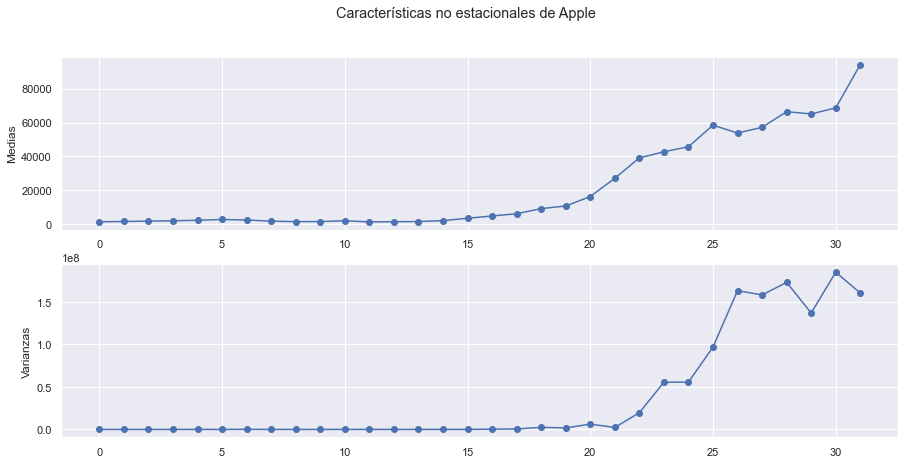

In [35]:
# Plotting means and variances

cols = ['means', 'variances']
df = pd.DataFrame([means,variances],index=cols)

sns.set(rc={'figure.figsize':(15, 7)})
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('Características no estacionales de Apple')

ax1.plot(means, 'o-')
ax1.set_ylabel('Medias')
ax1.set_xlabel('')

ax2.plot(variances, 'o-')
ax2.set_ylabel('Varianzas')
ax2.set_xlabel('')

plt.show()

Text(0.5, 1.0, 'Comportamiento Estacional')

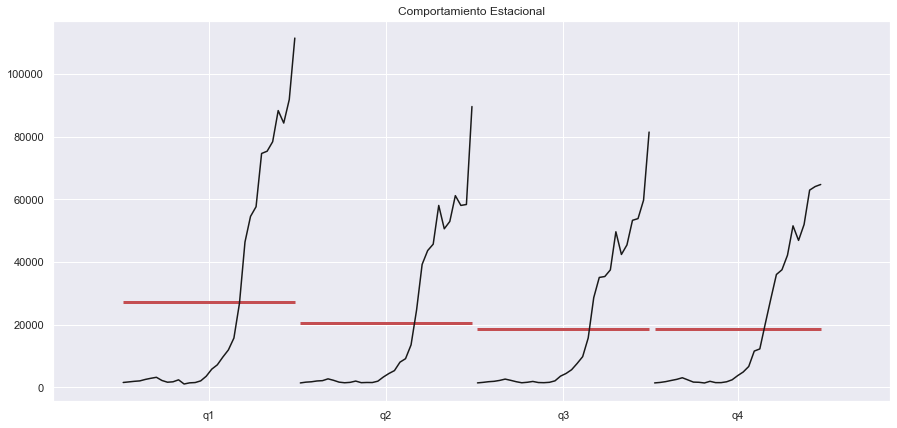

In [36]:
ax = plt.gca()
sm.graphics.tsa.quarter_plot(apple_ts_fy['Ingresos'],ax=ax)
ax.set_title('Comportamiento Estacional')

### Conclusiones sobre estacionariedad:
Como se puede observar los ingresos de apple no son estaciarios ni en media ni en varianza, ya que ambos cambian con el tiempo. 

En el primer gráfico se puedee observar como no solo hay una tendencia al crecimiento, sino que hay movimiento de oscilación dentro del año, siendo el 4 trimestre más importante en ventas. 

Con el segundo gráfico de media y varianza para períodos de 8Q´s se confirma quee tanto la media como la varianza ascienden con el tiempo. 



## Resumen de datos anuales

In [37]:
apple_ts_a_fy.tail()

,Ingresos
fecha,
2017-09-30,223507.0
2018-09-30,254634.0
2019-09-30,259034.0
2020-09-30,273857.0
2021-09-30,347155.0


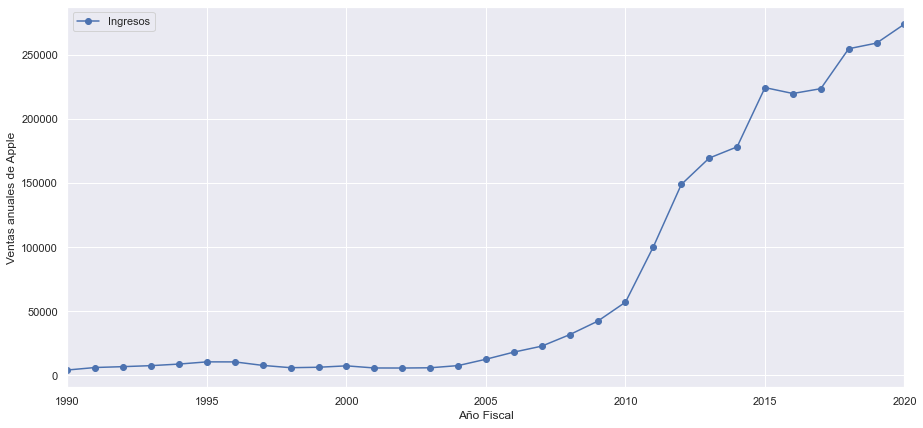

In [38]:
ax = apple_ts_q_fy[:'2020'].plot(marker='o', linestyle='-')
ax.set_ylabel('Ventas anuales de Apple')
ax.set_xlabel('Año Fiscal');

In [48]:
#crecimientos anuales de los ingresos

apple_sales_growth = apple_ts_q_fy.pct_change().mul(100).dropna()
mean=apple_sales_growth.mean()
apple_sales_growth.tail()
mean

Ingresos    17.6145
dtype: float64

Ingresos    9.971276
dtype: float64

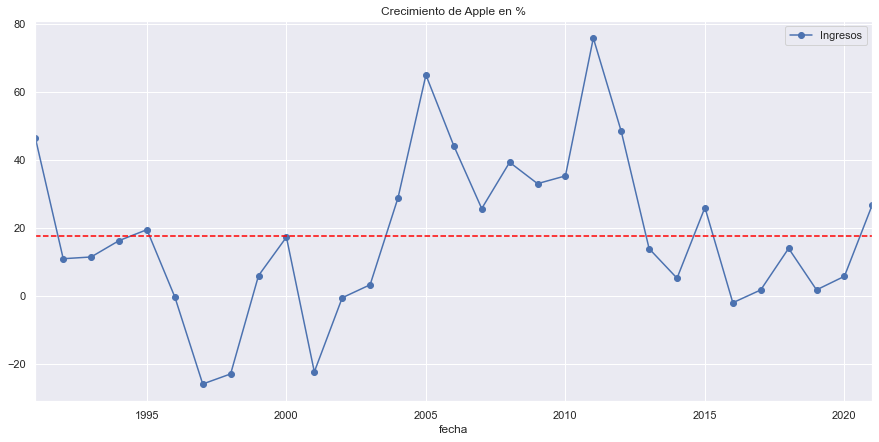

In [313]:
ax = apple_sales_growth.plot(marker='o', linestyle='-')
ax.set_title('Crecimiento de Apple en %')
ax.axhline(17.6145, color='red', linestyle='dashed')

## media de los últimos 5 años
apple_sales_growth.tail(n=5).mean()


## Modelo de Suavizado Exponencial
Separamos la muestra entre la parte de estimación y la parte de predicción


119 8


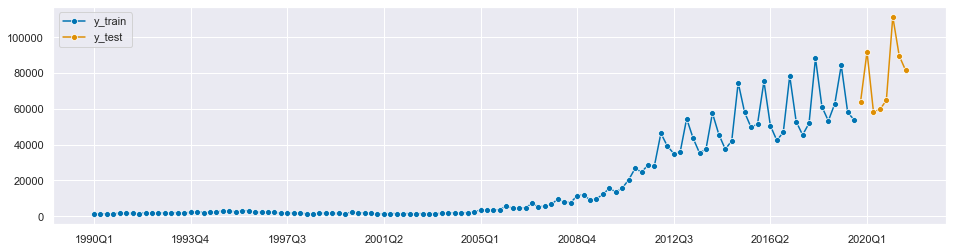

In [186]:
## Graficamos la los datos en dos partes, los que usaremos para test y los que usaremos para entrenar
y_train, y_test = temporal_train_test_split(y = apple_ts_fy['Ingresos'].astype('float64').to_period('Q-OCT'), test_size=8)
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

In [187]:
## vamos a forecastear el horizonte temporal de 8 Qs que son los que hemos dejado de testeo
fh8 = np.arange(1, 9)
apple_auto_model = AutoETS(auto=True, sp=4, n_jobs=-1)

In [188]:
apple_auto_model.fit(y_train)

AutoETS(auto=True, n_jobs=-1, sp=4)

In [189]:
print(apple_auto_model.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  119
Model:                       ETS(MAM)   Log Likelihood                -968.025
Date:                Mon, 01 Nov 2021   AIC                           1956.050
Time:                        12:32:04   BIC                           1983.841
Sample:                    01-31-1990   HQIC                          1967.335
                         - 07-31-2019   Scale                            0.018
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.4225      0.055      7.739      0.000       0.316       0.530
smoothing_trend        0.1685      0.034      4.890      0.000       0.101       0.236
smoothing_seasonal  

In [190]:
# step 5: querying predictions
apple_pred_1920 = apple_auto_model.predict(fh8)
apple_pred_1920
#apple_pred_1920 = apple_pred_1920['Ingresos'].astype('float64').to_period('Q-OCT')
#apple_df.resample('Q-OCT').last()


2019Q4    58581.329864
2020Q1    85963.046083
2020Q2    59751.803939
2020Q3    53079.531957
2020Q4    58323.474571
2021Q1    85584.248858
2021Q2    59488.216501
2021Q3    52845.119874
Freq: Q-OCT, dtype: float64

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

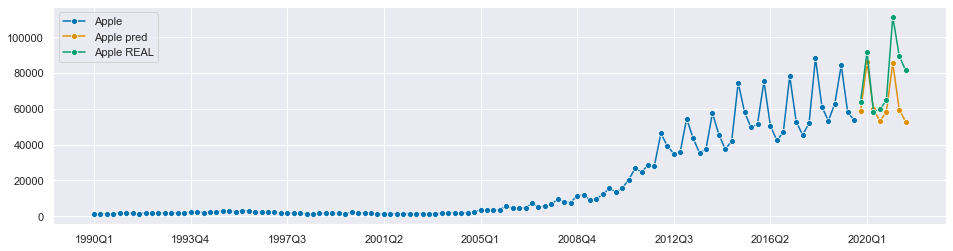

In [191]:
## plot to check the series with the predictions
plot_series(y_train, apple_pred_1920,y_test, labels=["Apple", "Apple pred", "Apple REAL"])

In [193]:
# option 1: using the lean function interface
mape_ets =mean_absolute_percentage_error(y_test, apple_pred_1920)
mape_ets

0.18651410968558557

In [194]:
mse = MeanSquaredError()
mse(y_test, apple_pred_1920)

317746827.88833416

In [195]:
rmse = MeanSquaredError(square_root=True)
rmse(y_test, apple_pred_1920)

17825.454493177283

In [196]:
## Forecasting next 6 Qs
fh6 = np.arange(1, 7)

# step 3: specifying the forecasting algorithm
apple_auto_model = AutoETS(auto=True, sp=4, n_jobs=-1)

y = apple_ts_fy['Ingresos'].astype('float64').to_period('Q-OCT')

apple_auto_model.fit(y)

print(apple_auto_model.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  127
Model:                       ETS(MAM)   Log Likelihood               -1052.310
Date:                Mon, 01 Nov 2021   AIC                           2124.620
Time:                        12:32:37   BIC                           2153.062
Sample:                    01-31-1990   HQIC                          2136.176
                         - 07-31-2021   Scale                            0.018
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.4303      0.055      7.816      0.000       0.322       0.538
smoothing_trend        0.1718      0.035      4.969      0.000       0.104       0.240
smoothing_seasonal  

In [197]:
# step 5: querying predictions
apple_pred_ets_2122 = apple_auto_model.predict(fh6)
print(apple_pred_ets_2122)

2021Q4     94928.198203
2022Q1    153907.757050
2022Q2    112068.412058
2022Q3    104446.064222
2022Q4    120404.571581
2023Q1    192615.716804
Freq: Q-OCT, dtype: float64


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

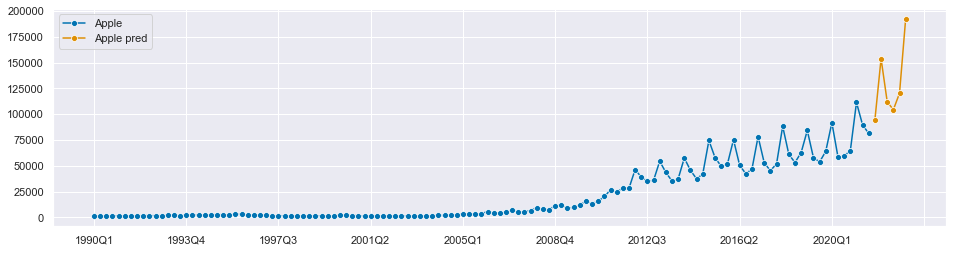

In [198]:
plot_series(y, apple_pred_ets_2122, labels=["Apple", "Apple pred"])

## ARIMA

In [200]:
# Apply Log Transformer
transformer = LogTransformer()
log_apple_ts_q= transformer.fit_transform(apple_ts_fy)
log_apple_ts_q.tail()

,Ingresos
fecha,
2020-07-31,10.996836
2020-10-31,11.077486
2021-01-31,11.621233
2021-04-30,11.402932
2021-07-31,11.307548


Text(0.5, 1.0, 'Ventas Apple: Transformación LOG')

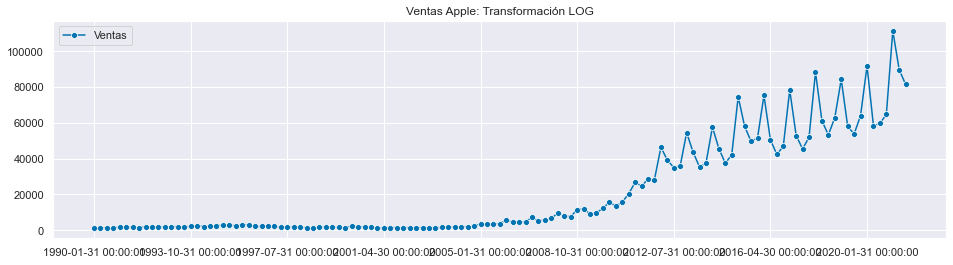

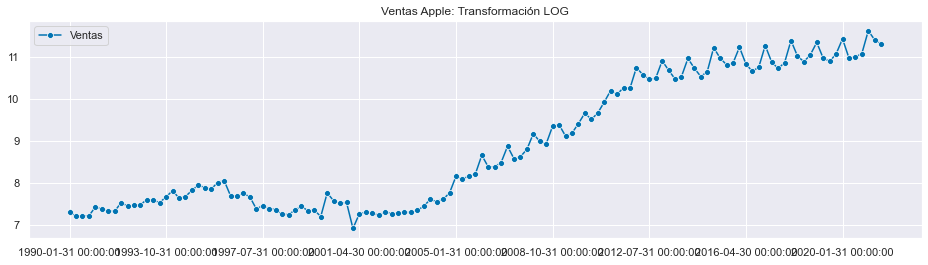

In [201]:
# Plogging original series and log data together
fig, ax = plot_series(apple_ts_fy, labels=["Ventas"])
ax.set_title('Ventas Apple: Transformación LOG')

fig, ax = plot_series(log_apple_ts_q, labels=["Ventas"])
ax.set_title('Ventas Apple: Transformación LOG')

## Estacionalidad

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

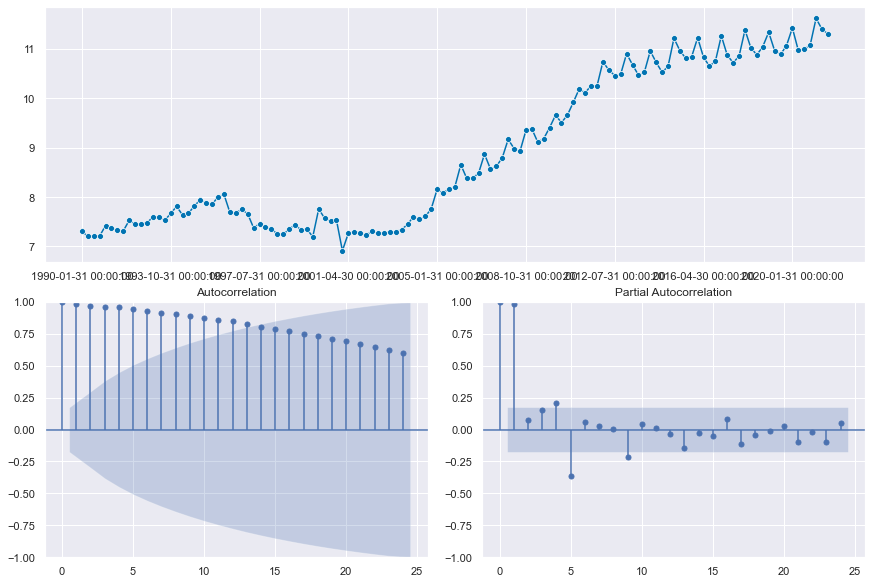

In [202]:
plot_correlations(log_apple_ts_q)

119 8


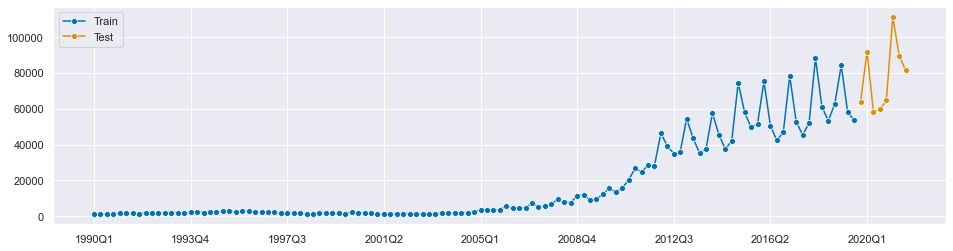

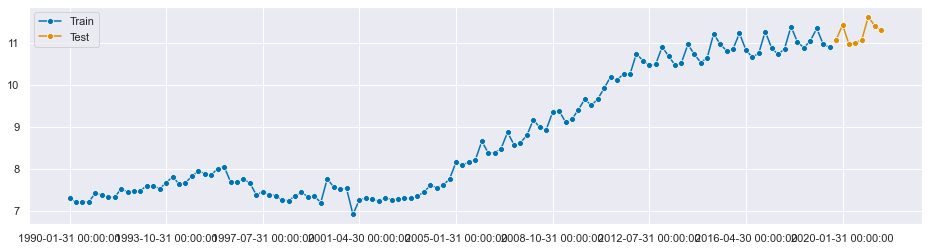

In [203]:
## Separamos la muestra logaritimica

log_y_train, log_y_test = temporal_train_test_split(y=log_apple_ts_q, test_size=8)
plot_series(y_train, y_test, labels=["Train", "Test"])
plot_series(log_y_train, log_y_test, labels=["Train", "Test"])
# Time Series Size
print(y_train.shape[0], y_test.shape[0])

In [204]:
forecaster = AutoARIMA(sp=4,suppress_warnings=True)
forecaster.fit(log_y_train)

AutoARIMA(sp=4, suppress_warnings=True)

In [205]:
#  Auto ARIMA Model Summary
print(forecaster.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  119
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 4)   Log Likelihood                  58.362
Date:                           Mon, 01 Nov 2021   AIC                           -108.724
Time:                                   12:33:30   BIC                            -97.642
Sample:                                        0   HQIC                          -104.224
                                           - 119                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3363      0.089     -3.795      0.000      -0.510      -0.163
ar.S.L4        0.9156      0.062     14.823

In [206]:

log_y_pred = forecaster.predict(fh8)
log_y_pred

/opt/anaconda3/envs/Series_Temporales/lib/python3.9/site-packages/sktime/utils/datetime.py:65: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
/opt/anaconda3/envs/Series_Temporales/lib/python3.9/site-packages/sktime/utils/datetime.py:66: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr


,Ingresos
2019-10-31,11.005156
2020-01-31,11.335688
2020-04-30,11.027220
2020-07-31,10.934802
2020-10-31,11.039463
2021-01-31,11.342092
2021-04-30,11.059665
2021-07-31,10.975048


In [208]:
#  Auto ARIMA Forecast
# Original Time series (Invert log transformation)
apple_pred_arima_1920 = np.exp(log_y_pred)
apple_pred_arima_1920 = apple_pred_arima_1920['Ingresos'].astype('float64').to_period('Q-OCT')
apple_pred_arima_1920

2019Q4    60183.637903
2020Q1    83758.059653
2020Q2    61526.313005
2020Q3    56094.986409
2020Q4    62284.194063
2021Q1    84296.171781
2021Q2    63555.240173
2021Q3    58398.652507
Freq: Q-OCT, Name: Ingresos, dtype: float64

In [209]:
mape_arima = mean_absolute_percentage_error(apple_pred_arima_1920,y_test)
mape_arima

0.156789696433304

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

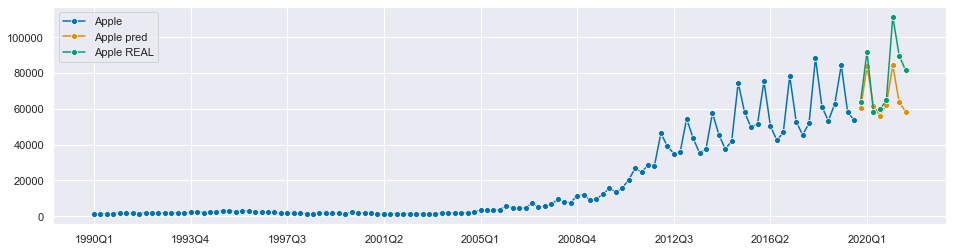

In [211]:
plot_series(y_train, apple_pred_arima_1920,y_test, labels=["Apple", "Apple pred", "Apple REAL"])

In [212]:
forecaster = AutoARIMA(sp=4,suppress_warnings=True)
forecaster.fit(log_apple_ts_q)

AutoARIMA(sp=4, suppress_warnings=True)

In [213]:
#  Auto ARIMA Model Summary
print(forecaster.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  127
Model:             SARIMAX(2, 1, 1)x(2, 0, 1, 4)   Log Likelihood                  65.973
Date:                           Mon, 01 Nov 2021   AIC                           -117.945
Time:                                   12:34:20   BIC                            -98.091
Sample:                                        0   HQIC                          -109.879
                                           - 127                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0879      0.214     -5.088      0.000      -1.507      -0.669
ar.L2         -0.3711      0.096     -3.868

In [214]:
#  Auto ARIMA Forecast
log_y_pred = forecaster.predict(fh6)
log_y_pred

/opt/anaconda3/envs/Series_Temporales/lib/python3.9/site-packages/sktime/utils/datetime.py:65: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
/opt/anaconda3/envs/Series_Temporales/lib/python3.9/site-packages/sktime/utils/datetime.py:66: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr


,Ingresos
2021-10-31,11.440423
2022-01-31,11.869057
2022-04-30,11.624029
2022-07-31,11.542784
2022-10-31,11.657231
2023-01-31,12.057065


In [219]:
apple_pred_arima_2122 =np.exp(log_y_pred)
apple_pred_arima_2122 = apple_pred_arima_2122['Ingresos'].astype('float64').to_period('Q-OCT')


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

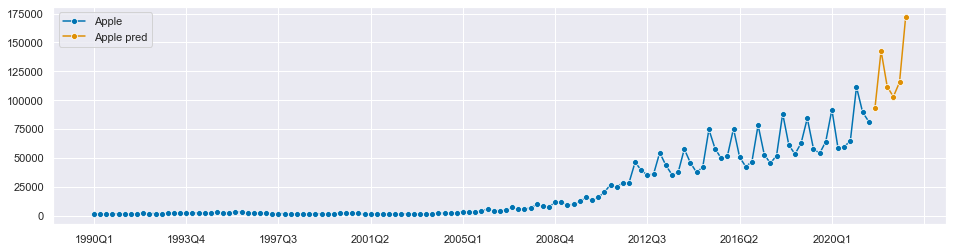

In [217]:
plot_series(apple_ts_fy['Ingresos'].astype('float64').to_period('Q-OCT'), apple_pred_arima_2122, labels=["Apple", "Apple pred"])

In [218]:
print(apple_pred_arima_2122)

2021Q4     93006.358882
2022Q1    142779.475501
2022Q2    111751.112659
2022Q3    103030.893315
2022Q4    115523.688548
2023Q1    172312.478269
Freq: Q-OCT, Name: Ingresos, dtype: float64


## Veremos los dos modelos juntos

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

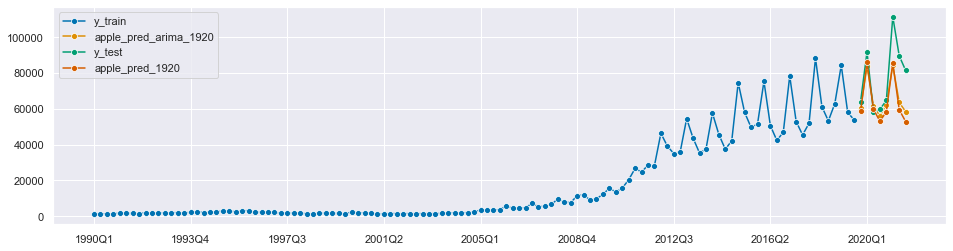

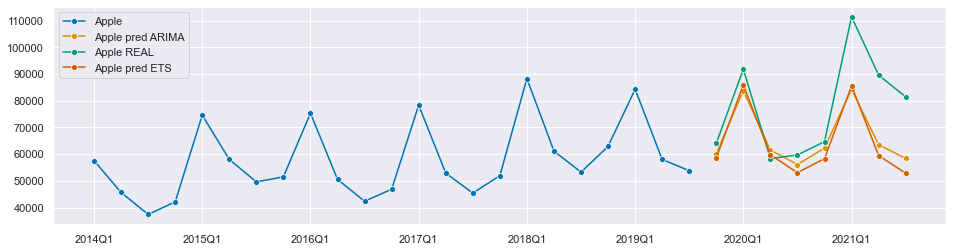

In [224]:
plot_series(y_train, apple_pred_arima_1920,y_test,apple_pred_1920, 
            labels=["y_train", "apple_pred_arima_1920", "y_test","apple_pred_1920"])
plot_series(y_train['2014':], apple_pred_arima_1920,y_test,apple_pred_1920,
            labels=["Apple", "Apple pred ARIMA", "Apple REAL","Apple pred ETS"])

## Analizando el período de Covid

In [234]:
## Creamos un Data Frame con nuestro modelo ARIMA y SME

df=pd.DataFrame({'Reales':y_test,'ARIMA':apple_pred_arima_1920.round(1),
                 'Diferencia':(y_test-apple_pred_arima_1920).round(1),
                 'Diff %':(y_test-apple_pred_arima_1920)/apple_pred_arima_1920})
df

,Reales,ARIMA,Diferencia,Diff %
2019Q4,64040.0,60183.6,3856.4,0.064077
2020Q1,91819.0,83758.1,8060.9,0.096241
2020Q2,58313.0,61526.3,-3213.3,-0.052227
2020Q3,59685.0,56095.0,3590.0,0.063999
2020Q4,64698.0,62284.2,2413.8,0.038755
2021Q1,111439.0,84296.2,27142.8,0.321994
2021Q2,89584.0,63555.2,26028.8,0.409545
2021Q3,81434.0,58398.7,23035.3,0.394450


Se puede observar que desde el Q2 del 2020 que empezó el covid, las ventas de apple crecieron más de lo esperado según el modelo, llegando a tener incluso diferencias de 40% con respecto a las predicciones. Parece que ha sido beneficiada por los efectos de la pandemia

In [ ]:
apple_ts_q

In [237]:
apple_pred_arima_2122

2021Q4     93006.358882
2022Q1    142779.475501
2022Q2    111751.112659
2022Q3    103030.893315
2022Q4    115523.688548
2023Q1    172312.478269
Freq: Q-OCT, Name: Ingresos, dtype: float64

In [238]:
df_pred=pd.DataFrame({'ARIMA':apple_pred_arima_2122.round(1),
                 'Diff %':(y_test-apple_pred_arima_1920)/apple_pred_arima_1920})

In [310]:
#joinning the real data with the predicctions from ARIMA MODEL
predicctions=apple_ts_fy['Ingresos'].astype('float64').to_period('Q-OCT').append(apple_pred_arima_2122) #join
#Resampling to get yearly summary
yearly_predicctions=predicctions.resample('A-OCT').sum()
yearly_predicctions.pct_change().mul(100).tail(10)

2014     6.953952
2015    27.856342
2016    -7.968680
2017     6.277808
2018    16.186339
2019    -2.041078
2020     5.512080
2021    36.773349
2022    26.000356
2023   -63.576859
Freq: A-OCT, Name: Ingresos, dtype: float64

In [312]:
df_pred=pd.DataFrame({'Año Fiscal':yearly_predicctions.index,'ARIMA':yearly_predicctions.round(1)})
df_pred=df_pred.tail(n=4).set_index('Año Fiscal')
df_pred['Barclays'] = [274515.0,368925,378619,0]
df_pred['Diff %'] = (df_pred['Barclays'] / df_pred['ARIMA'] -1)*100
df_pred['Crecimiento ARIMA']=df_pred['ARIMA'].pct_change().mul(100)
df_pred['Crecimiento Barclays']=df_pred['Barclays'].pct_change().mul(100)
df_pred = df_pred.head(n=3)
df_pred

,ARIMA,Barclays,Diff %,Crecimiento ARIMA,Crecimiento Barclays
Año Fiscal,,,,,
2020,274515.0,274515.0,0.000000,NaN,NaN
2021,375463.4,368925.0,-1.741421,36.773364,34.391563
2022,473085.2,378619.0,-19.968116,26.000351,2.627634
